# Ikeda $B_e$ assumtion.

In [1]:
from rolldecayestimators import equations

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


# Purpose
The quadratic or cubic model can be expressed using the linearized equivalent damping ($B_e$) according to <cite data-cite="7505983/EYEMHSYH">.:

In [2]:
equations.B_e_equation

Eq(B_e, B_1 + 8*B_2*omega0*phi_a/(3*pi))

In [3]:
equations.B_e_equation_cubic

Eq(B_e, B_1 + 8*B_2*omega0*phi_a/(3*pi) + 0.75*B_3*omega0**2*phi_a**2)

But I have some doubt about the validity of this, which will be investigated in this notebook.

# Methodology
A quadratic and cubic model from Simplified Ikeda will be used to calculate $B_e$. $B_e$ will also be obtained from Roll-decay simulations with these models, will the value be the same?

# WIP - improvements
(WORK IN PROGRESS)
Use this section only if the notebook is not final.

Notable TODOs:
* todo 1
* todo 2
* todo 3

## Results
Describe and comment the most important results.

# Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

In [4]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables


In [5]:
from rolldecayestimators.simplified_ikeda_class import SimplifiedIkeda
import rolldecayestimators
from scipy.integrate import solve_ivp

In [18]:
def calculate_B_n(X_amplitudes):
    B_ns=[None,]
    for i in range(len(X_amplitudes)-1):
        
        row1 = X_amplitudes.iloc[i]
        row2 = X_amplitudes.iloc[i+1]
        t_ = row2.name - row1.name
        B_n = zeta_lambda(omega0=row1['omega0'],phi_0=row1['phi_a'], phi_a=row2['phi_a'],
                t=t_)
        B_ns.append(B_n)
        
    return B_ns

## Linear

In [6]:
Math(vlatex(equations.roll_decay_equation_himeno_linear))

<IPython.core.display.Math object>

In [23]:
eq_acceleration_linear = sp.Eq(symbols.phi_dot_dot,
                        sp.solve(equations.roll_decay_equation_himeno_linear,symbols.phi_dot_dot)[0])
Math(vlatex(eq_acceleration_linear))

<IPython.core.display.Math object>

In [24]:
accelaration_linear_lambda = lambdify(sp.solve(equations.roll_decay_equation_himeno_linear,symbols.phi_dot_dot)[0])

## Quadratic

In [26]:
Math(vlatex(equations.roll_decay_equation_himeno_quadratic_b))

<IPython.core.display.Math object>

In [28]:
eq_acceleration_quadratic = sp.Eq(symbols.phi_dot_dot,
                        sp.solve(equations.roll_decay_equation_himeno_quadratic_b,symbols.phi_dot_dot)[0])

accelaration_quadratic_lambda = lambdify(sp.solve(equations.roll_decay_equation_himeno_quadratic_b,symbols.phi_dot_dot)[0])

Math(vlatex(eq_acceleration_quadratic))

<IPython.core.display.Math object>

In [29]:
class RollDecayLinear():
    
    def __init__(self,A_44, B_1, C_1):
        self.parameters = {
            'A_44':A_44,
            'B_1':B_1,
            'C_1':C_1,
        }
            
    def time_step(self,t,states):
        
        phi = states[0]
        phi1d = states[1]
        phi2d = accelaration_lambda(**self.parameters, phi=phi, phi1d=phi1d)
        
        d_states_dt = np.array([phi1d, phi2d])
        return d_states_dt
    
class RollDecayQuadratic():
    
    def __init__(self,A_44, B_1, B_2, C_1):
        self.parameters = {
            'A_44':A_44,
            'B_1':B_1,
            'B_2':B_2,
            'C_1':C_1,
        }
            
    def time_step(self,t,states):
        
        phi = states[0]
        phi1d = states[1]
        phi2d = accelaration_quadratic_lambda(**self.parameters, phi=phi, phi1d=phi1d)
        
        d_states_dt = np.array([phi1d, phi2d])
        return d_states_dt

In [305]:
N=100000
A_44 = 2.2
B_1 = 0.05
B_2 = 0.7
C_1 = 1.7

t = np.linspace(0,200,N)
phi0=np.deg2rad(10)
phi1d0 = 0
initial_state = [phi0,phi1d0]

simulations = {
    'linear':RollDecayLinear(A_44=A_44, B_1=B_1, C_1=C_1),
    'quadratic':RollDecayQuadratic(A_44=A_44, B_1=B_1, B_2=B_2, C_1=C_1),
}

In [306]:
equations.C_equation_linear

Eq(C, GM*g*m)

In [307]:
A_44_eq = sp.Eq(symbols.A_44, equations.A44)
A_44_eq

Eq(A_44, GM*g*m/omega0**2)

In [308]:
eqs = [
    A_44_eq,
    equations.C_equation_linear,

]
omega0_eq = sp.Eq(symbols.omega0,sp.solve(eqs, symbols.omega0, symbols.GM)[1][0])
omega0_eq

Eq(omega0, sqrt(C/A_44))

In [309]:
omega0 = np.sqrt(C_1/A_44)

In [310]:
t_span = [t[0], t[-1]]

results = {}
X_amplitudes = {}
for name,simulation in simulations.items():
    result = solve_ivp(fun=simulation.time_step, t_span=t_span,  y0=initial_state, t_eval=t)
    assert result.success
    df_result = pd.DataFrame(index=result.t, data=result.y.T, columns = ['phi','phi1d'])
    results[name]=df_result
    X_amplitudes[name]=rolldecayestimators.measure.calculate_amplitudes_and_damping(X=df_result)

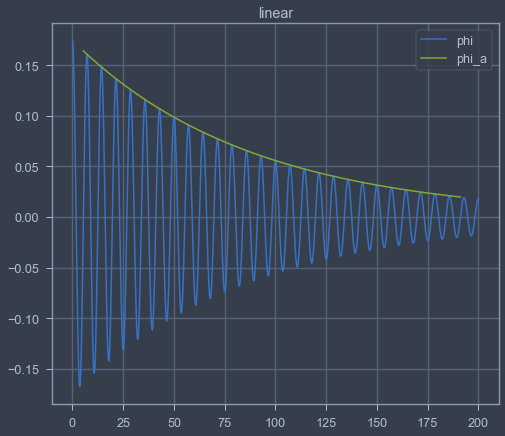

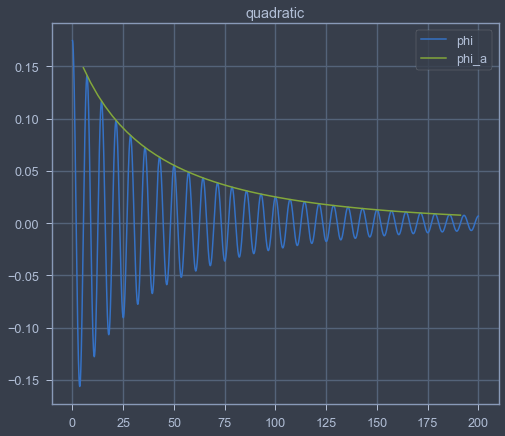

In [311]:
for name in results.keys():
    fig,ax=plt.subplots()
    df_result = results[name]
    amplitudes = X_amplitudes[name]
    df_result.plot(y='phi',ax=ax)
    amplitudes.plot(y='phi_a', ax=ax)
    ax.grid(True)
    ax.set_title(name)

In [312]:
equations.extinction_equation

Eq(phi_a, phi_0(t)*exp(-omega0*t*zeta))

In [313]:
sp.Eq(symbols.zeta,sp.solve(equations.extinction_equation,symbols.zeta)[0])

Eq(zeta, log(phi_0(t)/phi_a)/(omega0*t))

In [314]:
equations.B_e_equation

Eq(B_e, B_1 + 8*B_2*omega0*phi_a/(3*pi))

In [317]:
for name in results.keys():
    amplitudes = X_amplitudes[name]
    amplitudes['B_n2'] = calculate_B_n(amplitudes)
    
    omega0=amplitudes['omega0']
    phi_a=amplitudes['phi_a']
    B_e = B_1 + B_2*8/(3*np.pi)*omega0*phi_a
    amplitudes['B_1/2omega0'] = B_1/(2*omega0*A_44)
    amplitudes['B_e/2omega0'] = B_e/(2*omega0*A_44)
    

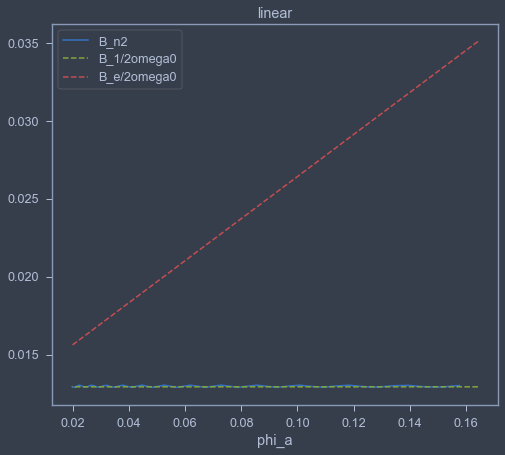

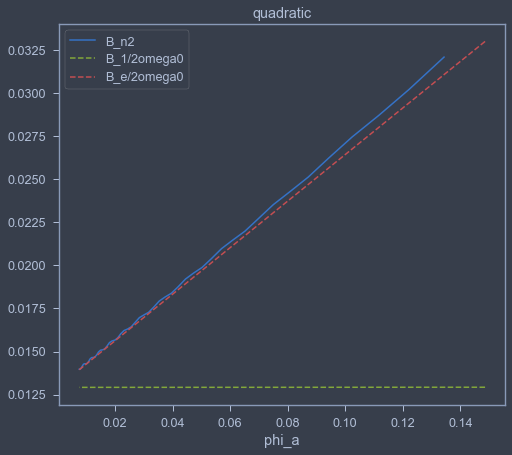

In [318]:
for name in results.keys():
    amplitudes = X_amplitudes[name]
    fig,ax=plt.subplots()
    amplitudes.plot(x='phi_a', y='B_n2', style='-', ax=ax)
    amplitudes.plot(x='phi_a', y='B_1/2omega0', style='--', ax=ax)
    amplitudes.plot(x='phi_a', y='B_e/2omega0', style='--',ax=ax)
    
    y_lim = ax.get_xlim()
    #ax.set_ylim(0,y_lim[1])
    ax.set_title(name)

In [290]:
amplitudes

,phi,phi1d,phi_a,zeta_n,B_n,omega0,B_n2,B_1/2omega0,B_e/2omega0
3.624365,0.260099,5.177065e-17,0.130050,0.052196,0.104393,1.301307,NaN,0.019211,0.075278
6.038547,0.218900,1.133804e-16,0.109450,0.047400,0.094799,1.301625,0.054892,0.019207,0.067324
8.451550,0.187373,1.106818e-16,0.093687,0.043575,0.087149,1.302208,0.049513,0.019198,0.061245
10.863570,0.162519,1.059113e-16,0.081260,0.040503,0.081005,1.302592,0.045307,0.019193,0.056446
13.275152,0.142496,1.692139e-16,0.071248,0.038067,0.076133,1.302807,0.041855,0.019189,0.052577
15.686374,0.126003,1.916162e-16,0.063002,0.036000,0.072001,1.303002,0.039157,0.019186,0.049388
18.097237,0.112183,4.219918e-17,0.056092,0.034178,0.068356,1.303191,0.036982,0.019184,0.046717
20.507758,0.100496,1.106657e-16,0.050248,0.032682,0.065364,1.303311,0.035023,0.019182,0.044456
22.918179,0.090504,1.907306e-16,0.045252,0.031451,0.062902,1.303363,0.033335,0.019181,0.042522
25.328509,0.081840,1.108444e-16,0.040920,0.030300,0.060600,1.303444,0.032030,0.019180,0.040846
